In [1]:
import argparse
import logging
import os
import sys

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split

sys.path.append("..")
sys.path.append("../scripts/")
import superlayer.utils

from scripts import eval_net, train_net, get_args

from superlayer.models import UNet, TiedUNet, SUnet, SLNet
from superlayer.utils import BrainD, dice_coeff, one_hot, plot_img_array, plot_side_by_side

In [2]:
dir_img = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
dir_mask = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/asegs/'
dir_checkpoint_1 = 'checkpoints_1/'
dir_checkpoint_2 = 'checkpoints_2/'

np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=10_000)

In [3]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
args = get_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

INFO: Using device cuda


In [4]:
target_label_numbers = [0,2,3,4,10,16,17,28,31,41,42,43,49,53,63]
val_percent = 0.1
batch_size = args.batchsize
lr = args.lr
img_scale = args.scale

dataset = BrainD(dir_img, dir_mask, label_numbers=target_label_numbers)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - 2 * n_val
n_test = n_val
train, val, test = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=8, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')

INFO: Creating dataset with 7329 examples


In [5]:
one_example = next(iter(train_loader))

image = one_example['image'][0]
mask = one_example['mask'][0]

print(image.shape)
print(mask.shape)

sq_img = image.squeeze(0).squeeze(0)
sq_msk = mask.squeeze(0).squeeze(0)

torch.Size([1, 160, 192])
torch.Size([1, 160, 192])


torch.Size([160, 192])


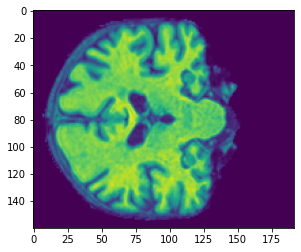

In [6]:
print(sq_img.shape)
plt.imshow(sq_img)

torch.Size([160, 192])


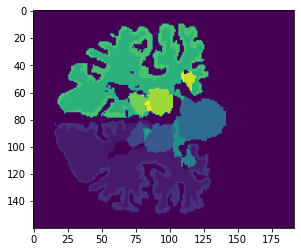

In [7]:
print(sq_msk.shape)
plt.imshow(sq_msk)

In [ ]:
net1 = UNet(n_channels=1, n_classes=15, bilinear=True)

logging.info(f'Network:\n'
             f'\t{1} input channels\n'
             f'\t{15} output channels (classes)\n')

net1.to(device=device)
train_scores1, val_scores1, train_var_1, val_var_1 = train_net(net=net1,
                                                                epochs=1,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=1,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

INFO: Network:
	1 input channels
	15 output channels (classes)

INFO: Starting training:
        Epochs:          1
        Batch size:      8
        Learning rate:   0.001
        Training size:   6597
        Validation size: 732
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
    
Validation round: 100%|██████████| 91/91 [00:10<00:00, 11.45batch/s]
                                                                    INFO: Validation Dice Loss: 0.06966877139204151
Validation round:  99%|█████████▉| 90/91 [00:09<00:00, 12.18batch/s]
                                                                    INFO: Validation Dice Loss: 0.05503970769407985
Validation round:   1%|          | 1/91 [00:01<02:17,  1.53s/batch]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 12.02batch/s]
                                                                    INFO: Validation Dice Loss: 0.05615433944123132
Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 10.77batch/s]
                                                                    INFO: Validation Dice Loss: 0.05146834557200526
Validation round:  13%|█▎        | 12/91 [00:02<00:14,  5.40batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.61batch/s]
                                                                    INFO: Validation Dice Loss: 0.050416918246300665
Epoch 1/1:  59%|█████▉    | 3888/6597 [02:30<01:01, 43.72img/s, loss (batch)=0.102] 

In [ ]:
net2 = TiedUNet(in_channels=1, nshared=64, n_classes=15, enc_depth=4, bilinear=True)

logging.info(f'Network:\n'
             f'\t{net2.in_channels} input channels\n'
             f'\t{net2.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net2.bilinear else "Transposed conv"} upscaling')

net2.to(device=device)
train_scores2, val_scores2, train_var_2, val_var_2 = train_net(net=net2,
                                                                epochs=1,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=2,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

In [ ]:
enc_nf = [4, 8, 16, 32]
dec_nf = [32, 16, 8, 4]
net3 = SUnet(input_ch=1, out_ch=15, use_bn=True, enc_nf=enc_nf, dec_nf=dec_nf, ignore_last=False)

logging.info(f'Network:\n'
             f'\t{1} input channels\n'
             f'\t{15} output channels (classes)\n')

net3.to(device=device)
train_scores3, val_scores3, train_var_3, val_var_3 = train_net(net=net3,
                                                                epochs=1,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=1,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

In [ ]:
enc_nf = [4, 8, 16, 32]
dec_nf = [32, 16, 8, 4]
net4 = SLNet(input_ch=1, out_ch=15, use_bn=True, superblock_size=64, depth=4)

logging.info(f'Network:\n'
             f'\t{1} input channels\n'
             f'\t{15} output channels (classes)\n')

net4.to(device=device)
train_scores4, val_scores4, train_var_4, val_var_4 = train_net(net=net4,
                                                                epochs=1,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=1,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

In [ ]:
print("configuring plot one")
domain = len(train_scores1)
x_values = [i+1 for i in range(domain)]
plt.title("UNet")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores1, color="blue", label="train")
plt.plot(x_values, val_scores1, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

In [ ]:
print("configuring plot two")
domain = len(train_scores2)
x_values = [i+1 for i in range(domain)]
plt.title("SL-Net")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores2, color="blue", label="train")
plt.plot(x_values, val_scores2, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

In [ ]:
print("configuring plot three")
domain = len(train_scores3)
x_values = [i+1 for i in range(domain)]
plt.title("Simple Net")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores3, color="blue", label="train")
plt.plot(x_values, val_scores3, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

In [ ]:
print("configuring plot four")
domain = len(train_scores4)
x_values = [i+1 for i in range(domain)]
plt.title("Simple TiedNet")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores4, color="blue", label="train")
plt.plot(x_values, val_scores4, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

In [ ]:
import math

# Create another simulation dataset for test
train_loader = DataLoader(train, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
val_loader = DataLoader(val, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
test_loader = DataLoader(test, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

# Get the first batch
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))
test_batch = next(iter(test_loader))

inputs_train = train_batch['image']
labels_train = train_batch['mask']

inputs_val = val_batch['image']
labels_val = val_batch['mask']

inputs_test = test_batch['image']
labels_test = test_batch['mask']

In [ ]:
net1.eval() 
inputs = inputs_train.to(device=device, dtype=torch.float32)
labels = labels_train.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net1.eval() 
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = inputs_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net1.eval() 
inputs = inputs_test.to(device=device, dtype=torch.float32)
labels = labels_test.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net2.eval()
inputs = inputs_train.to(device=device, dtype=torch.float32)
labels = labels_train.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net2.eval()
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = labels_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net2.eval()
inputs = inputs_test.to(device=device, dtype=torch.float32)
labels = labels_test.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net4.eval()
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = labels_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net4(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])